In [1]:
import  tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
Using TensorFlow backend.


In [2]:
timeFrame = 10
LSTM_units = 256
Dense_units = 1

In [3]:
#dataSPY = pd.read_csv('SPY (1).csv')
#dataAAPL = pd.read_csv('AAPL.csv')
#data = pd.concat([dataSPY, dataAAPL])
data = pd.read_csv('SPY (1).csv')
#data = pd.read_csv('AAPL.csv')
cl = data.Close
vol = data.Volume

In [4]:
scl = MinMaxScaler()
scl_1 = MinMaxScaler()
cl = cl.values.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
vol = vol.values.reshape(vol.shape[0],1)
vol = scl_1.fit_transform(vol)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
def increment(c, v, period):
    X,Y = [], []
    for i in range(len(c)-period-1):
        A = []
        A.append(c[i:(i+period),0])
        A.append(v[i:(i+period),0])
        Y.append(c[(i+period),0])
        X.append(A)
    return np.array(X),np.array(Y)

X,Y = increment(cl, vol, timeFrame)

X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
Y_train, Y_test = Y[:int(Y.shape[0]*0.80)], Y[int(Y.shape[0]*0.80):]

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
model = Sequential()
model.add(LSTM(LSTM_units, input_shape = (2, timeFrame)))
model.add(Dense(Dense_units))
model.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])
stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.00001, patience = 10,
                     verbose = 0, mode = 'auto')

#, callbacks = [stop]

start = time.time()

History = model.fit(X_train, Y_train, epochs = 20, validation_split = 0.20, shuffle = False, verbose = 1)

end = time.time()
print(end - start)

Train on 799 samples, validate on 200 samples
Epoch 1/20
799/799 [==============================] - 1s 1ms/step - loss: 0.0067 - acc: 0.0013 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 2/20
799/799 [==============================] - 0s 241us/step - loss: 0.0039 - acc: 0.0013 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 3/20
799/799 [==============================] - 0s 244us/step - loss: 0.0022 - acc: 0.0013 - val_loss: 3.3603e-04 - val_acc: 0.0000e+00
Epoch 4/20
799/799 [==============================] - 0s 237us/step - loss: 6.8798e-04 - acc: 0.0013 - val_loss: 2.7690e-04 - val_acc: 0.0000e+00
Epoch 5/20
799/799 [==============================] - 0s 239us/step - loss: 4.8879e-04 - acc: 0.0013 - val_loss: 4.7648e-04 - val_acc: 0.0000e+00
Epoch 6/20
799/799 [==============================] - 0s 236us/step - loss: 4.4825e-04 - acc: 0.0013 - val_loss: 3.8372e-04 - val_acc: 0.0000e+00
Epoch 7/20
799/799 [==============================] - 0s 241us/step - loss: 4.2577e-04 - acc: 0.0013

In [7]:
def calcPercentCorrect (X_test, Y_test, period, scl, XT):
    XT.reshape(-1, 1)
    X_test1 = []
    Y_test1 = []
    XT1 = []
    up = []
    numUp = 0
    buy = []
    numBuy = 0
    numCorrect = 0
    for i in range (X_test.shape[0]-1):
        X_test1.extend(scl.inverse_transform(X_test[i][1][(period-1)]))
        Y_test1.extend(scl.inverse_transform(Y_test[i]))
        XT1.extend(scl.inverse_transform(XT[i][0]))
    for i in range (X_test.shape[0]-1):
        if (Y_test1[i] > Y_test1[(i-1)]):
            up.append(True)
            numUp = (numUp + 1)
        else:
            up.append(False)
    for i in range (X_test.shape[0]-1):
        if (XT1[i] > Y_test1[i]):
            buy.append(True)
            numBuy = (numBuy + 1)
        else:
            buy.append(False)
    for i in range (X_test.shape[0]-1):
        if (buy[i] == up[i]):
            if (buy[i] == 1):
                numCorrect = (numCorrect + 1)
    print(numUp, numBuy)
    return ((numCorrect/(len(buy)))*100)

XT = model.predict(X_test)
percent = calcPercentCorrect(X_test, Y_test, timeFrame, scl, XT)
print (percent)

145 118
18.473895582329316


PREDICTIONS: 
over: 
119
under: 
131
percent over: 
47.599999999999994

ACTUAL: 
up: 
145
down: 
104
percent over: 
58.23293172690763


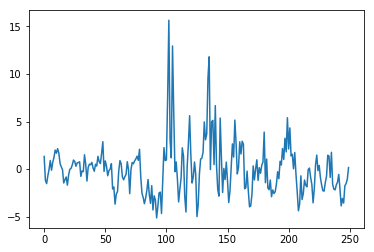

In [8]:
Xt = model.predict(X_test)
plt.plot((scl.inverse_transform(Xt))-(scl.inverse_transform(Y_test.reshape(-1,1))))
over = 0
under = 0
for i in range ((scl.inverse_transform(Xt)).shape[0]):
    if ((scl.inverse_transform(Xt))[i] > (scl.inverse_transform(Y_test.reshape(-1,1)))[i]):
        over = (over + 1)
    else:
        under = (under + 1)
print ('PREDICTIONS: ')
print ('over: ')
print (over)
print ('under: ')
print (under)
print ('percent over: ')
print (100*(over / (over + under)))
print ()

up = 0
down = 0
for i in range ((scl.inverse_transform(Y_test.reshape(-1,1))).shape[0]-1):
    if (((scl.inverse_transform(Y_test.reshape(-1,1)))[i+1]) > ((scl.inverse_transform(Y_test.reshape(-1,1)))[i])):
        up = (up + 1)
    else:
        down = (down + 1)
print ('ACTUAL: ')
print ('up: ')
print (up)
print ('down: ')
print (down)
print ('percent over: ')
print (100*(up / (up + down)))

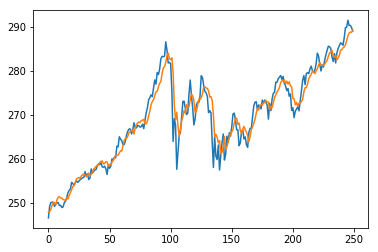

In [9]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(Y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

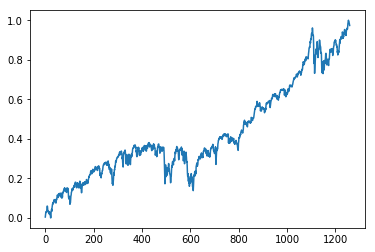

In [10]:
plt.plot(cl)

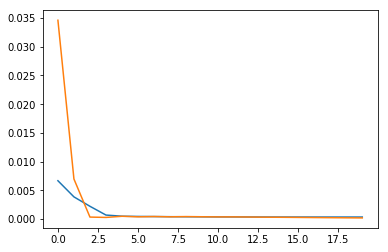

In [11]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])

I am only getting around 20% correct buy signals. I need to train more but if I train more it over fits to the data.  The solution is adding dropout to the mix to add in some artificial noise but if I add in dropout I wont have enough data. I really just need more data.